1. Importing Libraries

In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

2. Load the Dataset

In [3]:
df = pd.read_csv('labeled_data.csv')

In [4]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


3. Preprocess Tweetes

In [5]:
def preprocess_tweet(text):
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^A-Za-z\s]', '', text)
  text = text.lower().strip()
  return text

df['clean_tweet'] = df['tweet'].apply(preprocess_tweet)

In [6]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about cle...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad for cuffin dat h...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she sta...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true o...


4. Prepare Features and Labels

In [7]:
X = df['clean_tweet']
y = df['class']

5. Split the Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 19826
Testing set size: 4957


6. Create a Pipeline

In [9]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.9, min_df=5)),
    ('clf', LogisticRegression(class_weight='balanced', solver='liblinear'))
])

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],           # unigrams, bigrams, trigrams
    'tfidf__max_df': [0.7, 0.9],                        # max document frequency
    'tfidf__min_df': [1, 5],                              # min document frequency
    'tfidf__max_features': [1000, 3000],                # vocabulary size
    'clf__C': [0.1, 1.0, 10],                            # regularization strength
}

7. Train the model with GridSearchCV

In [10]:
# pipeline.fit(X_train, y_train)
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=3, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


8. Make Predictions and Evaluate

Accuracy: 0.8819850716158967
F1 Score (macro): 0.731082343493238
Classification Report:
               precision    recall  f1-score   support

 Hate Speech       0.40      0.46      0.43       290
   Offensive       0.95      0.91      0.93      3832
     Neither       0.78      0.90      0.84       835

    accuracy                           0.88      4957
   macro avg       0.71      0.76      0.73      4957
weighted avg       0.89      0.88      0.89      4957



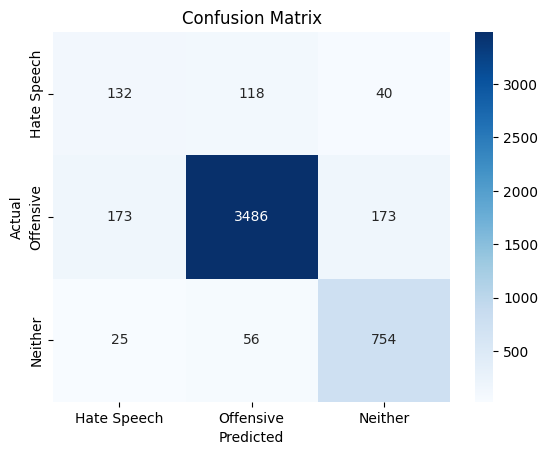

In [11]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Hate Speech", "Offensive", "Neither"]))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Hate Speech", "Offensive", "Neither"],
            yticklabels=["Hate Speech", "Offensive", "Neither"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


9. Save the model

In [12]:
import joblib
joblib.dump(pipeline, "hateSpeech_classifier.pkl")

['hateSpeech_classifier.pkl']